In [38]:
import pandas as pd
import numpy as np
import os
import sys
import glob
import re
import json
import shutil
import sys

sys.path.append(r"C:\Users\janbe\Documents\GitHub Repos\pulse")
from src.eval.metrics import calculate_all_metrics

In [39]:
outputfolder_path_list = [
    r"C:\Users\janbe\Documents\GitHub Repos\pulse\output\llama_sys_msg_test"
]

In [40]:
def categorize_files(outputfolder_path_list):
    """
    Categorize files in the output folders into metrics report files, metadata files, and log files.

    Args:
        outputfolder_path_list (list): List of output folder paths.

    Returns:
        dict: A dictionary containing categorized files.
    """
    file_list = []
    for outputfolder_path in outputfolder_path_list:
        file_list.extend(glob.glob(os.path.join(outputfolder_path, "*")))

    categorized_files = {
        "metrics_report_files": [f for f in file_list if "metrics_report" in f],
        "metadata_files": [f for f in file_list if "metadata" in f],
        "log_files": [f for f in file_list if "log" in f],
    }

    print("Metrics Report Files:")
    for file in categorized_files["metrics_report_files"]:
        print(file)
    print("\nMetadata Files:")
    for file in categorized_files["metadata_files"]:
        print(file)
    print("\nLog Files:")
    for file in categorized_files["log_files"]:
        print(file)

    return categorized_files
    

In [41]:
def load_metadata(metadata_path_list):
    """
    Load metadata from a CSV file into a DataFrame.
    
    Args:
        metadata_path (str): Path to the metadata CSV file.
        
    Returns:
        pd.DataFrame: DataFrame containing the metadata.
    """
    df_mdata = pd.DataFrame()
    for m_path in metadata_path_list:
        try:
            df = pd.read_csv(m_path)
            # Extract model name, task, dataset, and timestamp from the metadata path
            match = re.search(
                r"\\([^\\]+)_([^_]+)_([^_]+)_(\d{8}_\d{6})_metadata\.csv$", m_path
            )
            if match:
                model_name, task, dataset, timestamp = match.groups()
                print(f"Model Name: {model_name}, Task: {task}, Dataset: {dataset}, Timestamp: {timestamp}")
                # Add extracted metadata to the DataFrame
                df['model_name'] = model_name
                df['task'] = task
                df['dataset'] = dataset
                df['timestamp'] = timestamp

            else:
                print("Failed to extract metadata details from the path. Using default values.")
                df['model_name'] = "Unknown"
                df['task'] = "Unknown"
                df['dataset'] = "Unknown"
                df['timestamp'] = "Unknown"
            
            # Append the DataFrame to the main DataFrame
            df_mdata = pd.concat([df_mdata, df], ignore_index=True)

        except Exception as e:
            print(f"Error loading metadata: {e}")
            continue
    return df_mdata

In [42]:
def load_metrics_report_as_df(metrics_report_path):
    """
    Load metrics report from a JSON file and return it as a DataFrame.
    
    Args:
        metrics_report_path (str): Path to the metrics report JSON file.
        
    Returns:
        pd.DataFrame: DataFrame containing the metrics report.
    """
    try:
        with open(metrics_report_path, 'r') as f:
            metrics_report = json.load(f)
        df = pd.DataFrame(metrics_report)
        return df
    except Exception as e:
        print(f"Error loading metrics report: {e}")
        return None

In [43]:
def get_predictions_by_model_task_dataset(df, model, task, dataset):
    """
    Filter predictions DataFrame by model, task, and dataset.

    Args:
        df (DataFrame): DataFrame containing predictions.
        model (str): Model name to filter by.
        task (str): Task name to filter by.
        dataset (str): Dataset name to filter by.

    Returns:
        DataFrame: Filtered DataFrame with predictions.
    """
    return df[(df['model_name'] == model) & (df['task'] == task) & (df['dataset'] == dataset)]

In [44]:
def get_predictions_by_task_dataset(df, task, dataset):
    """
    Filter predictions DataFrame by task and dataset.

    Args:
        df (DataFrame): DataFrame containing predictions.
        task (str): Task name to filter by.
        dataset (str): Dataset name to filter by.

    Returns:
        DataFrame: Filtered DataFrame with predictions.
    """
    return df[(df["task"] == task) & (df["dataset"] == dataset)]

In [45]:
def get_predictions_by_model(df, model):
    """
    Filter predictions DataFrame by model.

    Args:
        df (DataFrame): DataFrame containing predictions.
        model (str): Model name to filter by.

    Returns:
        DataFrame: Filtered DataFrame with predictions.
    """
    return df[df["model_name"] == model]

In [46]:
cat_files = categorize_files(outputfolder_path_list)

Metrics Report Files:
C:\Users\janbe\Documents\GitHub Repos\pulse\output\llama_sys_msg_test\Llama3Model_metrics_report.json

Metadata Files:
C:\Users\janbe\Documents\GitHub Repos\pulse\output\llama_sys_msg_test\Llama3Model_aki_eicu_20250602_105157_metadata.csv
C:\Users\janbe\Documents\GitHub Repos\pulse\output\llama_sys_msg_test\Llama3Model_mortality_eicu_20250602_105157_metadata.csv
C:\Users\janbe\Documents\GitHub Repos\pulse\output\llama_sys_msg_test\Llama3Model_sepsis_eicu_20250602_105157_metadata.csv

Log Files:
C:\Users\janbe\Documents\GitHub Repos\pulse\output\llama_sys_msg_test\log_20250602_105157.log


In [47]:
df_metadata = load_metadata(cat_files["metadata_files"])

Model Name: Llama3Model, Task: aki, Dataset: eicu, Timestamp: 20250602_105157
Model Name: Llama3Model, Task: mortality, Dataset: eicu, Timestamp: 20250602_105157
Model Name: Llama3Model, Task: sepsis, Dataset: eicu, Timestamp: 20250602_105157


In [48]:
df_metadata.head(20)

,Input Prompt,Target Label,Predicted Probability,Predicted Diagnosis,Predicted Explanation,Tokenization Time,Inference Time,Input Tokens,Output Tokens,System Message,System Message Index,model_name,task,dataset,timestamp
0,Suggest a diagnosis of aki for the following p...,0,0.02,not-aki,"The patient's creatinine level is 0.9 mg/dL, w...",0.004373,4.796369,1821,110,You are a helpful assistant and experienced me...,0,Llama3Model,aki,eicu,20250602_105157
1,Suggest a diagnosis of aki for the following p...,0,0.50,unknown,No explanation provided.,0.003515,11.615228,1823,300,"As a medical AI, analyze ICU data for **Acute ...",1,Llama3Model,aki,eicu,20250602_105157
2,Suggest a diagnosis of aki for the following p...,0,0.00,not-aki,The patient's mean creatinine level is 0.9 mg/...,0.003687,3.026729,1937,75,You are an experienced medical AI analyzing IC...,2,Llama3Model,aki,eicu,20250602_105157
3,Suggest a diagnosis of aki for the following p...,0,0.01,not-aki,Serum creatinine is stable at 0.9 mg/dL; urine...,0.003722,3.980423,1985,100,You are an expert medical AI assistant special...,3,Llama3Model,aki,eicu,20250602_105157
4,Suggest a diagnosis of aki for the following p...,0,0.02,not-aki,"The patient's creatinine level is 0.9 mg/dL, w...",0.003356,4.234463,1821,107,You are a helpful assistant and experienced me...,0,Llama3Model,aki,eicu,20250602_105157
5,Suggest a diagnosis of aki for the following p...,0,0.50,unknown,No explanation provided.,0.003398,11.616256,1823,300,"As a medical AI, analyze ICU data for **Acute ...",1,Llama3Model,aki,eicu,20250602_105157
6,Suggest a diagnosis of aki for the following p...,0,0.00,not-aki,The patient's mean creatinine level is 0.9 mg/...,0.003654,3.016756,1937,75,You are an experienced medical AI analyzing IC...,2,Llama3Model,aki,eicu,20250602_105157
7,Suggest a diagnosis of aki for the following p...,0,0.00,not-aki,Patient's creatinine level is stable at 0.9 mg...,0.003677,3.632453,1985,91,You are an expert medical AI assistant special...,3,Llama3Model,aki,eicu,20250602_105157
8,Suggest a diagnosis of aki for the following p...,0,0.02,not-aki,"The patient's creatinine level is 0.9 mg/dL, w...",0.003370,4.234310,1821,107,You are a helpful assistant and experienced me...,0,Llama3Model,aki,eicu,20250602_105157
9,Suggest a diagnosis of aki for the following p...,0,0.90,aki,Elevated creatinine levels and low urine outpu...,0.003379,10.393286,1823,268,"As a medical AI, analyze ICU data for **Acute ...",1,Llama3Model,aki,eicu,20250602_105157


In [49]:
import matplotlib.pyplot as plt
def plot_metrics(df):
    # Calculate all metrics for each unique System Message Index
    metrics_by_sys_msg_idx = {}

    for idx in df["System Message Index"].unique():
        subset = df[df["System Message Index"] == idx]
        y_true = subset['Target Label'].values
        y_pred = subset['Predicted Probability'].values
        metrics = calculate_all_metrics(y_true, y_pred)
        metrics_by_sys_msg_idx[idx] = metrics

    # Prepare data for plotting
    indices = list(metrics_by_sys_msg_idx.keys())
    metrics_names = list(next(iter(metrics_by_sys_msg_idx.values())).keys())

    # Collect values for each metric across all indices
    metric_values = {metric: [metrics_by_sys_msg_idx[idx][metric] for idx in indices] for metric in metrics_names}

    # Create a grouped bar plot: x-axis = metric, bars = System Message Index
    bar_width = 0.2
    x = np.arange(len(metrics_names))

    plt.figure(figsize=(14, 6))
    for i, idx in enumerate(indices):
        values = [metrics_by_sys_msg_idx[idx][metric] for metric in metrics_names]
        plt.bar(x + i * bar_width, values, width=bar_width, label=f'System Msg {idx}')

    plt.xticks(x + bar_width * (len(indices) - 1) / 2, metrics_names, rotation=45, ha='right')
    plt.ylabel('Metric Value')
    plt.title('Metrics by System Message (Grouped by Metric)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

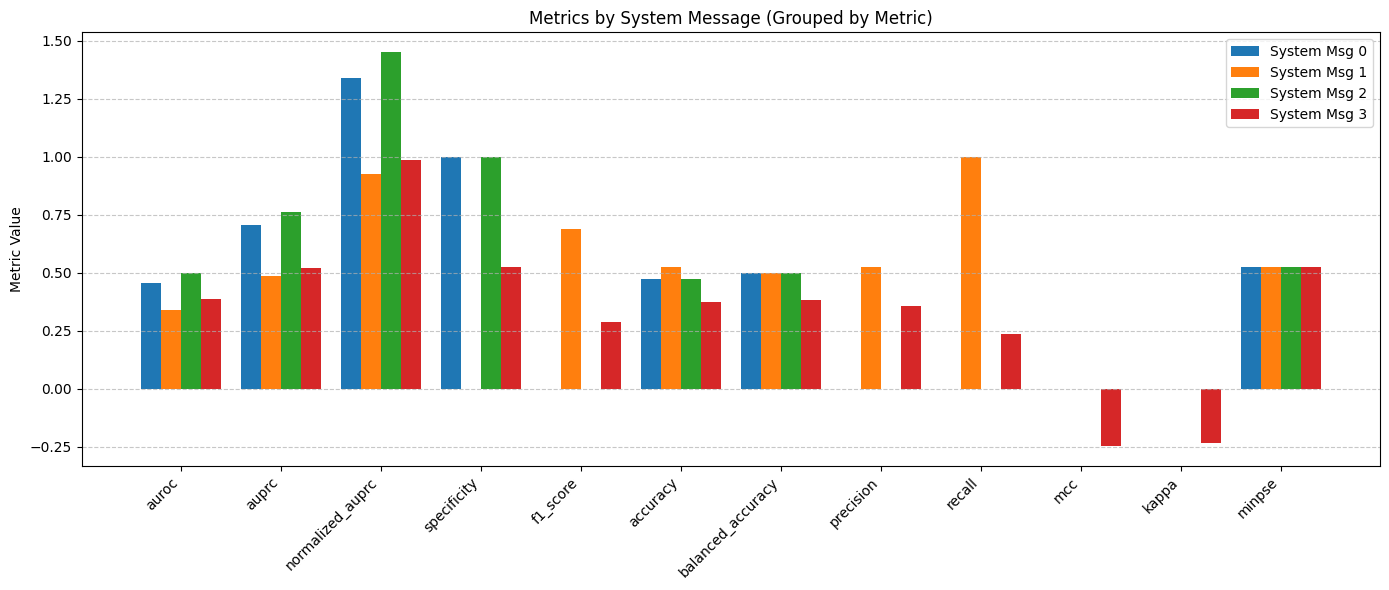

In [50]:
df = get_predictions_by_model_task_dataset(df_metadata, "Llama3Model", "aki", "eicu")
plot_metrics(df)

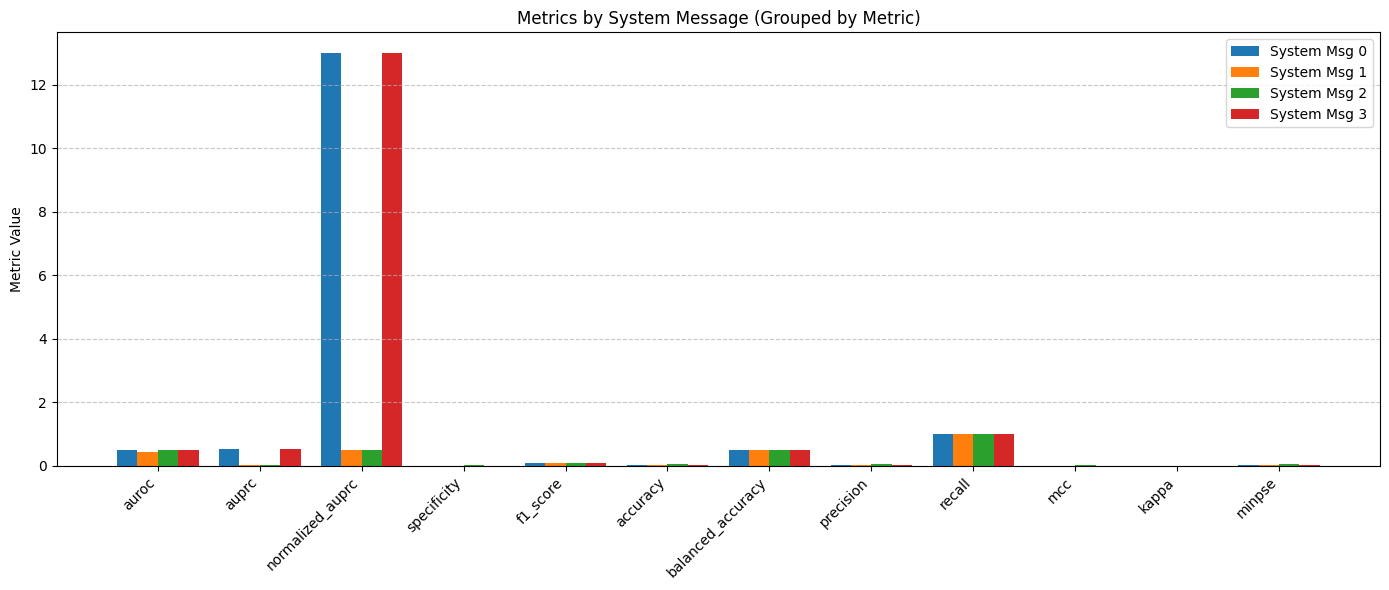

In [51]:
df = get_predictions_by_model_task_dataset(df_metadata, "Llama3Model", "mortality", "eicu")
plot_metrics(df)

Only one class present in y_true. Returning NaN
Only one class present in y_true. Returning 0.0
c:\Users\janbe\Documents\GitHub Repos\pulse\.venv\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\janbe\Documents\GitHub Repos\pulse\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
Only one class present in y_true. Returning NaN
Only one class present in y_true. Returning 0.0
c:\Users\janbe\Documents\GitHub Repos\pulse\.venv\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\janbe\Documents\GitHub Repos\pulse\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to

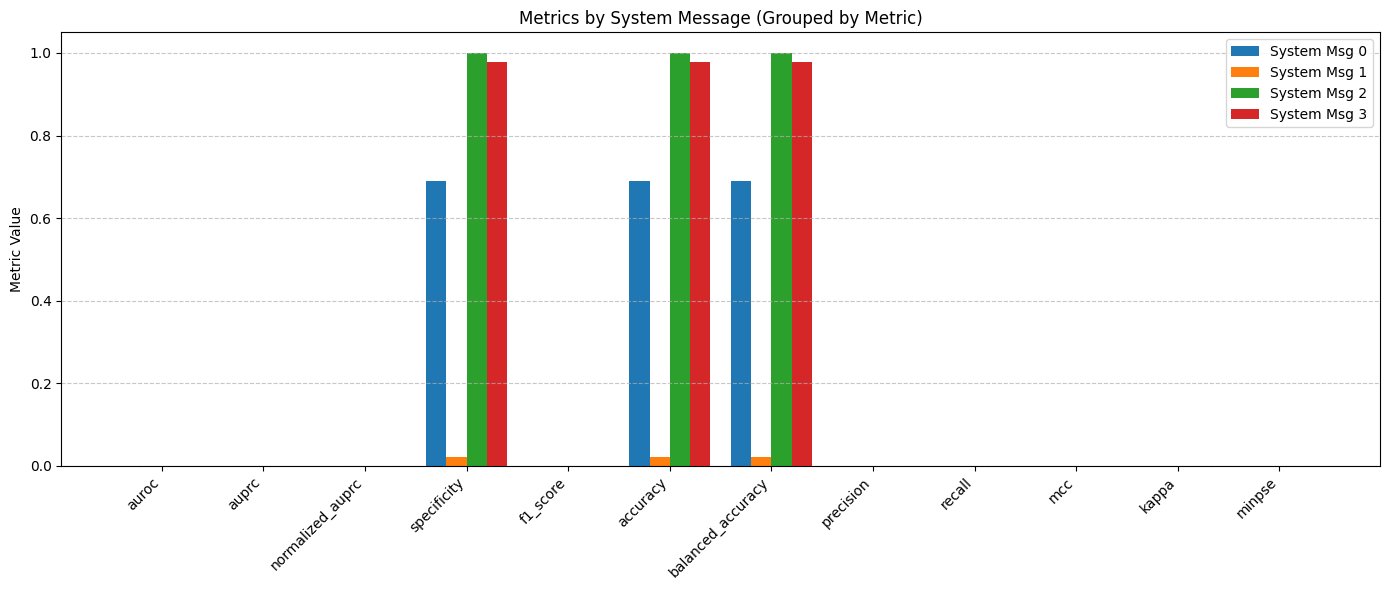

In [52]:
df = get_predictions_by_model_task_dataset(
    df_metadata, "Llama3Model", "sepsis", "eicu"
)
plot_metrics(df)